In [1]:
import sys
import os

# Set the Python path to the root directory
sys.path.append(os.path.abspath(os.path.join('..')))

# Load and Examine Data

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
items_df = pd.read_csv('../data/items.csv')
item_categories_df = pd.read_csv('../data/item_categories.csv')
shops_df = pd.read_csv('../data/shops.csv')

##### Display the first few rows of each dataset

In [4]:
data.head(), test_df.head(), items_df.head(), item_categories_df.head(), shops_df.head()

(   Unnamed: 0        date  date_block_num  shop_id  item_id  item_price  \
 0           0  02.01.2013               0       59    22154      999.00   
 1           1  03.01.2013               0       25     2552      899.00   
 2           2  05.01.2013               0       25     2552      899.00   
 3           3  06.01.2013               0       25     2554     1709.05   
 4           4  15.01.2013               0       25     2555     1099.00   
 
    item_cnt_day  item_category_id  
 0           1.0                37  
 1           1.0                58  
 2          -1.0                58  
 3           1.0                58  
 4           1.0                56  ,
    ID  shop_id  item_id
 0   0        5     5037
 1   1        5     5320
 2   2        5     5233
 3   3        5     5232
 4   4        5     5268,
    item_id  item_category_id
 0        0                40
 1        1                76
 2        2                40
 3        3                40
 4        4       

# Data Preprocessing

##### Handle missing values

In [5]:
train_missing = data.isnull().sum()
test_missing = test_df.isnull().sum()
items_missing = items_df.isnull().sum()
item_categories_missing = item_categories_df.isnull().sum()
shops_missing = shops_df.isnull().sum()

train_missing, test_missing, items_missing, item_categories_missing, shops_missing

(Unnamed: 0          0
 date                0
 date_block_num      0
 shop_id             0
 item_id             0
 item_price          0
 item_cnt_day        0
 item_category_id    0
 dtype: int64,
 ID         0
 shop_id    0
 item_id    0
 dtype: int64,
 item_id             0
 item_category_id    0
 dtype: int64,
 item_category_id    0
 dtype: int64,
 shop_id    0
 dtype: int64)

##### Feature engineering

In [6]:
# Convert date column to datetime format
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Extract month from the date
data['month'] = data['date'].dt.month

# Since the test data doesn't have the date column, we'll assign the month of November (month 11) to it
test_df['month'] = 11

# Aggregate sales data by month
monthly_sales = data.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
    'item_cnt_day': 'sum', 
    'month': 'first',
    'item_price': 'mean'
}).reset_index()
monthly_sales.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'avg_item_price'}, inplace=True)

# Merge data
data_merged = pd.merge(monthly_sales, items_df, on='item_id', how='left')
data_merged = pd.merge(data_merged, item_categories_df, on='item_category_id', how='left')
data_merged = pd.merge(data_merged, shops_df, on='shop_id', how='left')

# For test data, add date_block_num for November 2015
test_df['date_block_num'] = 34
test_df_merged = pd.merge(test_df, items_df, on='item_id', how='left')
test_df_merged = pd.merge(test_df_merged, item_categories_df, on='item_category_id', how='left')
test_df_merged = pd.merge(test_df_merged, shops_df, on='shop_id', how='left')

data_merged

,date_block_num,shop_id,item_id,item_cnt_month,month,avg_item_price,item_category_id
0,0,0,32,6.0,1,221.0,40
1,0,0,33,3.0,1,347.0,37
2,0,0,35,1.0,1,247.0,40
3,0,0,43,1.0,1,221.0,40
4,0,0,51,2.0,1,128.5,57
...,...,...,...,...,...,...,...
1609119,33,59,22087,6.0,10,119.0,83
1609120,33,59,22088,2.0,10,119.0,83
1609121,33,59,22091,1.0,10,179.0,83
1609122,33,59,22100,1.0,10,629.0,42


In [7]:
from scripts.feature_engineering import LagFeatures, FillNA
from sklearn.pipeline import Pipeline

In [8]:
target = 'item_cnt_month'
date_block_col = 'date_block_num'

# Apply the feature engineering pipeline to the combined data
data_pipeline = Pipeline(steps=[
    ('lag_amounts', LagFeatures(lags=[1, 2, 3], col=target)),
    ('lag_avg_prices', LagFeatures(lags=[1], col='avg_item_price')),
    ('fill_na', FillNA())
])
data_processed = data_pipeline.fit_transform(data_merged)

features_to_drop = [target, date_block_col, 'avg_item_price']
X = data_processed.drop(columns=features_to_drop)
y = data_processed[target]

# Model Training and Evaluation

##### Hyperparameter Tuning

In [9]:
from sklearn.model_selection import BaseCrossValidator
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [10]:
class CustomTimeSeriesSplitter(BaseCrossValidator):
    def __init__(self, n_splits, date_col='date_block_num'):
        self.n_splits = n_splits
        self.date_col = date_col

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        unique_dates = np.sort(X[self.date_col].unique())
        n_dates = len(unique_dates)
        
        if self.n_splits >= n_dates:
            raise ValueError("Number of splits must be less than the number of unique dates.")

        test_start_idx = n_dates - self.n_splits

        for i in range(test_start_idx, n_dates):
            train_idx = X[X[self.date_col] < unique_dates[i]].index
            test_idx = X[X[self.date_col] == unique_dates[i]].index
            yield train_idx, test_idx

# Number of last months to use for validation
n_splits = 3
# CustomTimeSeriesSplitter(n_splits=n_splits, date_col='date_block_num')
splitter = CustomTimeSeriesSplitter(n_splits=n_splits, date_col='date_block_num')

In [11]:
# Perform hyperparameter tuning
param_grid = {
    'max_depth': [5],
    'learning_rate': [0.03, 0.05],
    'n_estimators': [150, 200],
    'subsample': [0.5, 0.6, 0.7],
    # 'colsample_bytree': [0.7, 0.8, 0.9],
    'min_split_loss': [4, 5, 6, 7],
    # 'reg_alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [0.1, 0.2, 0.3]
}

# Initialize the model
xgb = XGBRegressor(objective='reg:squarederror')

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=splitter, scoring='neg_mean_squared_error', verbose=5, n_jobs=-1)
grid_search.fit(data_processed.drop(columns=[target, 'avg_item_price']), data_processed[target])

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=CustomTimeSeriesSplitter(date_col='date_block_num', n_splits=3),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importanc...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.03, 0.05], 'max_depth': [5],
                         'min_split_loss': [4, 5, 6, 7],
                         'n_estimators': [150, 200],
                         'reg_lambda': [0.1, 0.2, 0.3],
                         'subsample': [0.5, 0.6, 0.7]},
             scoring='neg_mean_squared_error', verbose=5)

In [12]:
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best RMSE: {np.sqrt(-grid_search.best_score_)}')

Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_split_loss': 5, 'n_estimators': 200, 'reg_lambda': 0.3, 'subsample': 0.6}
Best RMSE: 12.53808057998365


##### Split Training and Validation sets

In [13]:
# Use the last month in the training data for validation
validation_block_num = 33

train_data = data_processed[data_processed[date_block_col] < validation_block_num]
val_data = data_processed[data_processed[date_block_col] == validation_block_num]

X_train = train_data.drop(columns=features_to_drop)
y_train = train_data[target]
X_val = val_data.drop(columns=features_to_drop)
y_val = val_data[target]
X_train, y_train, X_val, y_val

(         shop_id  item_id  month  item_category_id  item_cnt_month_lag_1  \
 0              0       32      1                40                   0.0   
 1              0       33      1                37                   0.0   
 2              0       35      1                40                   0.0   
 3              0       43      1                40                   0.0   
 4              0       51      1                57                   0.0   
 ...          ...      ...    ...               ...                   ...   
 1577588       59    22087      9                83                   2.0   
 1577589       59    22088      9                83                   7.0   
 1577590       59    22091      9                83                   0.0   
 1577591       59    22100      9                42                   0.0   
 1577592       59    22139      9                38                   0.0   
 
          item_cnt_month_lag_2  item_cnt_month_lag_3  avg_item_price_lag_1

##### Model Training

In [14]:
# Best parameters from GridSearchCV
# model_params = {'learning_rate': 0.05, 'max_depth': 5, 'min_split_loss': 5, 'n_estimators': 200, 'reg_lambda': 0.3, 'subsample': 0.6}
model_params = grid_search.best_params_

# Setting early stopping rounds
early_stopping_rounds = 0.1 * model_params['n_estimators']

# Train XGBoost model
model = XGBRegressor(objective='reg:squarederror',
                     **model_params,
                    #  n_estimators=200,
                    #  subsample=0.7,
                    #  max_depth=7,
                    #  colsample_bytree=0.9,
                    #  learning_rate=0.05,
                    #  reg_alpha=0.1,
                    #  reg_lambda=0.1
                     early_stopping_rounds=early_stopping_rounds,
                     )

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-rmse:8.31556	validation_1-rmse:14.40554
[1]	validation_0-rmse:8.15644	validation_1-rmse:14.29621
[2]	validation_0-rmse:8.00659	validation_1-rmse:14.19345
[3]	validation_0-rmse:7.85843	validation_1-rmse:14.09344
[4]	validation_0-rmse:7.73294	validation_1-rmse:14.01902
[5]	validation_0-rmse:7.61671	validation_1-rmse:13.95661
[6]	validation_0-rmse:7.51708	validation_1-rmse:13.89110
[7]	validation_0-rmse:7.43376	validation_1-rmse:13.82895
[8]	validation_0-rmse:7.33585	validation_1-rmse:13.75339
[9]	validation_0-rmse:7.24049	validation_1-rmse:13.67446
[10]	validation_0-rmse:7.16905	validation_1-rmse:13.62425
[11]	validation_0-rmse:7.10321	validation_1-rmse:13.59089
[12]	validation_0-rmse:7.04030	validation_1-rmse:13.57201
[13]	validation_0-rmse:6.99085	validation_1-rmse:13.54846
[14]	validation_0-rmse:6.93890	validation_1-rmse:13.48081
[15]	validation_0-rmse:6.87522	validation_1-rmse:13.44831
[16]	validation_0-rmse:6.82282	validation_1-rmse:13.42380
[17]	validation_0-rmse:6

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=20.0,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, min_split_loss=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

##### Feature Importance Plot

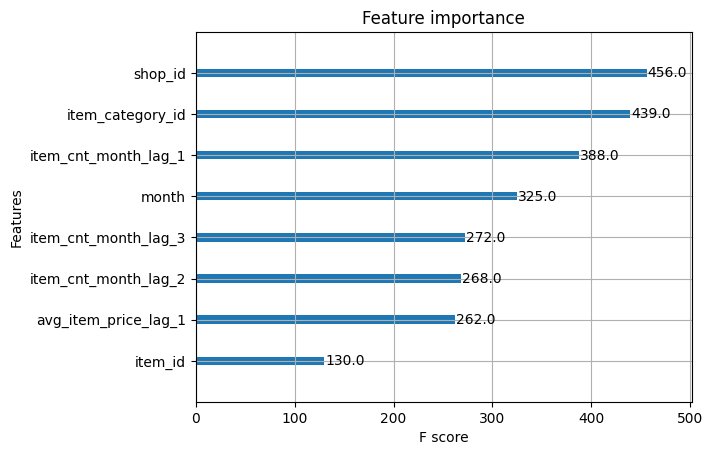

In [15]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Plot feature importance
xgb.plot_importance(model, max_num_features=20)
plt.show()

##### Model Evaluation

In [16]:
# Make predictions
y_pred = model.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

13.09659871250922

# Test data prediction

In [17]:
# Combine the train and test data
test_df_merged[target] = 0  # Add a dummy column for item_cnt_month

combined_df = pd.concat([data_merged, test_df_merged], ignore_index=True)

combined_df_transformed = data_pipeline.fit_transform(combined_df)

# Separate back into train and test sets
train_df_transformed = combined_df_transformed[combined_df_transformed['date_block_num'] < 34]
test_df_transformed = combined_df_transformed[combined_df_transformed['date_block_num'] == 34]

# Drop unnecessary columns for prediction
test_features = test_df_transformed.drop(columns=features_to_drop + ['ID'])

test_features

,shop_id,item_id,month,item_category_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,avg_item_price_lag_1
1609124,5,5037,11,19,0.0,1.0,3.0,0.0
1609125,5,5320,11,55,0.0,0.0,0.0,0.0
1609126,5,5233,11,19,1.0,3.0,1.0,1199.0
1609127,5,5232,11,23,0.0,0.0,1.0,0.0
1609128,5,5268,11,20,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1823319,45,18454,11,55,1.0,0.0,0.0,99.0
1823320,45,16188,11,64,0.0,0.0,0.0,0.0
1823321,45,15757,11,55,0.0,0.0,0.0,0.0
1823322,45,19648,11,40,0.0,0.0,0.0,0.0


In [18]:
# Make predictions on the test set
test_predictions = model.predict(test_features)

test_predictions

array([1.8990268, 1.4033291, 1.9695035, ..., 1.481494 , 1.5963022,
       1.8521519], dtype=float32)

In [20]:
# Create the submission file
submission = pd.DataFrame({
    'ID': test_df_merged['ID'],
    'item_cnt_month': test_predictions.round()
})

submission.to_csv('../data/submission.csv', index=False)
print("Submission file created successfully!")

Submission file created successfully!


# Saving the Model and Data

In [21]:
import joblib

# Save the model
joblib.dump(model, '../models/xgboost_model.pkl')

['../models/xgboost_model.pkl']

In [22]:
data_merged.to_csv('../data/data_merged.csv', index=False)